In [1]:
import os
import glob
import bz2
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

# Preprocessing the Quotebank data

The idea with this notebook is to load the prefiltered Quotebank data set and preprocess it such that we have an unambiguous data frame that is suitable for future investigations as a pickle. We start by loading the data from each yearly `json.bz2`-file such that the yearly dataframes are concatenated into a single one.

In [2]:
# Specifying filename and directory
data_dir = os.getcwd() + os.sep + 'data'
quotebank_dir = data_dir + os.sep + "Quotebank"
quotebank_bz2 = os.listdir(quotebank_dir)
print(quotebank_bz2)

# Change directory
os.chdir(quotebank_dir)

['quotes-2015-movies.json.bz2', 'quotes-2016-movies.json.bz2', 'quotes-2017-movies.json.bz2', 'quotes-2018-movies.json.bz2', 'quotes-2019-movies.json.bz2', 'quotes-2020-movies.json.bz2']


In [3]:
df = pd.DataFrame()
for year_file in tqdm(quotebank_bz2):
    if year_file != '.DS_Store':
        temp =  pd.read_json(year_file, lines=True, compression='bz2')
        df = pd.concat([df, temp], ignore_index = True) 
df.shape

  0%|          | 0/6 [00:00<?, ?it/s]

(67736, 10)

In [4]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2015-02-14-007911,For fans of the book they know that Effie's ro...,None,[],2015-02-14 00:47:05,1,"[[None, 0.8008], [Francis Lawrence, 0.1299], [...",[http://www.buzzfeed.com/kristinharris/secrets...,E,The Hunger Games: Mockingjay - Part 2
1,2015-11-15-027947,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15 03:15:53,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,E,The Hunger Games: Mockingjay - Part 2
2,2015-04-26-028061,It's pretty exciting-I have to say. I saw the ...,None,[],2015-04-26 11:56:10,2,"[[None, 0.8589], [Jared Leto, 0.0772], [Joss W...",[http://ign.com/articles/2015/04/24/joss-whedo...,E,Star Wars: Episode VII - The Force Awakens
3,2015-12-31-028469,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31 16:48:00,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,E,Star Wars: Episode VII - The Force Awakens
4,2015-12-10-059754,Is Daredevil joining the Avengers for Infinity...,None,[],2015-12-10 23:18:29,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,E,Avengers: Age of Ultron


Removing NaN-values. We see that these only occur in the `movie` attribute which right now is due to an issue in the data filtering. 

In [5]:
df.isnull().any()

quoteID           False
quotation         False
speaker           False
qids              False
date              False
numOccurrences    False
probas            False
urls              False
phase             False
movie             False
dtype: bool

In [6]:
df = df.loc[-df.isnull().any(axis=1)]

In [7]:
df.shape

(67736, 10)

### Dealing with the speakers

We investigate how many quotes does not have an obvious speaker and is denoted by 'None'. Turns out that it is approximately 38%.

In [8]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 25588
Total fraction of 'None'-speakers: 0.37776071808196526


Even though the single speakers are not really important for answering our research questions, we choose to clean the data by chaning 'None'-speakers to the speaker with second highest probability from the `df.probas` attribute.

In [9]:
# Removes speaker as being None to being the second most likely in case speaker is 'None'
proba_threshhold = 0.15

secondary_speaker = [df['probas'][i][1][0] if (speaker == 'None') and (float(df['probas'][i][1][1]) > proba_threshhold) else speaker for i, speaker in enumerate(tqdm(df['speaker']))]
df['speaker'] = secondary_speaker

  0%|          | 0/67736 [00:00<?, ?it/s]

In [10]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 10121
Total fraction of 'None'-speakers: 0.14941832998700838


In [11]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2015-02-14-007911,For fans of the book they know that Effie's ro...,None,[],2015-02-14 00:47:05,1,"[[None, 0.8008], [Francis Lawrence, 0.1299], [...",[http://www.buzzfeed.com/kristinharris/secrets...,E,The Hunger Games: Mockingjay - Part 2
1,2015-11-15-027947,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15 03:15:53,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,E,The Hunger Games: Mockingjay - Part 2
2,2015-04-26-028061,It's pretty exciting-I have to say. I saw the ...,None,[],2015-04-26 11:56:10,2,"[[None, 0.8589], [Jared Leto, 0.0772], [Joss W...",[http://ign.com/articles/2015/04/24/joss-whedo...,E,Star Wars: Episode VII - The Force Awakens
3,2015-12-31-028469,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31 16:48:00,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,E,Star Wars: Episode VII - The Force Awakens
4,2015-12-10-059754,Is Daredevil joining the Avengers for Infinity...,Scott Davis,[],2015-12-10 23:18:29,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,E,Avengers: Age of Ultron


Furthermore, we realize that there is a super specific timestamp on the `date` attribute. Later on we will match daily box office sales with the Quotebank data, so we strip the timestamps from the specific time of the date and focus solely on the date.

In [12]:
# Remove last part of date from the quoteID date string to be able to have an average daily sentiment score
reduced_dates = [("-").join(date.split("-")[:3]) for date in tqdm(df.quoteID)]
df['date'] = reduced_dates

  0%|          | 0/67736 [00:00<?, ?it/s]

In [13]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2015-02-14-007911,For fans of the book they know that Effie's ro...,None,[],2015-02-14,1,"[[None, 0.8008], [Francis Lawrence, 0.1299], [...",[http://www.buzzfeed.com/kristinharris/secrets...,E,The Hunger Games: Mockingjay - Part 2
1,2015-11-15-027947,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,E,The Hunger Games: Mockingjay - Part 2
2,2015-04-26-028061,It's pretty exciting-I have to say. I saw the ...,None,[],2015-04-26,2,"[[None, 0.8589], [Jared Leto, 0.0772], [Joss W...",[http://ign.com/articles/2015/04/24/joss-whedo...,E,Star Wars: Episode VII - The Force Awakens
3,2015-12-31-028469,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,E,Star Wars: Episode VII - The Force Awakens
4,2015-12-10-059754,Is Daredevil joining the Avengers for Infinity...,Scott Davis,[],2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,E,Avengers: Age of Ultron


The attribute `phase` seem to mostly take the values 'E'. The investigation below shows that all of the entries are in fact 'E' so we decide to remove it from the dataframe. From the documentation of the data we also do not find it relevant for our case. Also we won't be using the `quoteID` attribute but instead the WikiData compatible `qids`.

In [14]:
np.unique(df.phase, return_counts=True)
df = df.drop(['phase', 'quoteID'], axis=1)

### Handling outliers in the numOccurrences

We want to check for outliers in the number of occurrences as it is the only numercal attribute left. We note that there are no weird negative values as the minimum value of occurrences is 1.

In [15]:
df.numOccurrences.describe()

count    67736.000000
mean         8.763700
std        444.275087
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      58945.000000
Name: numOccurrences, dtype: float64

The boxplot reveals that there is a need to investigate outliers and the plot of the occurences reveal that the distribution seem to follow a strong power law. We will have to qualitatively analyze these to be able to determine whether this tendency seems real or is due to spam. We will determine this later on when we have adjusted the data for other issues.

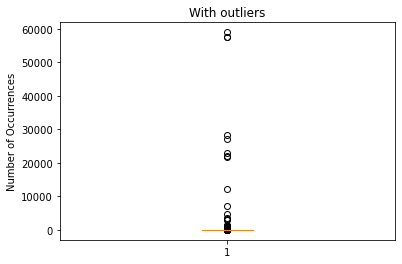

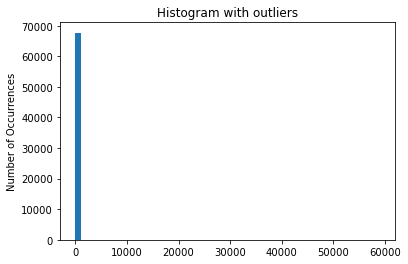

In [16]:
plt.boxplot(df.numOccurrences)
plt.ylabel("Number of Occurrences")
plt.title("With outliers")
plt.show()

plt.hist(df.numOccurrences, bins=50)
plt.ylabel("Number of Occurrences")
plt.title("Histogram with outliers")
plt.show()

In [17]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,For fans of the book they know that Effie's ro...,None,[],2015-02-14,1,"[[None, 0.8008], [Francis Lawrence, 0.1299], [...",[http://www.buzzfeed.com/kristinharris/secrets...,The Hunger Games: Mockingjay - Part 2
1,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2
2,It's pretty exciting-I have to say. I saw the ...,None,[],2015-04-26,2,"[[None, 0.8589], [Jared Leto, 0.0772], [Joss W...",[http://ign.com/articles/2015/04/24/joss-whedo...,Star Wars: Episode VII - The Force Awakens
3,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens
4,Is Daredevil joining the Avengers for Infinity...,Scott Davis,[],2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron


### Dealing with the quoter-IDs

Furthermore, we see that the `qids` might need some engineering. In the initial analyses on the 2019 NYT data we saw that some individuals are quoted differently even though it's in fact the same speaker. For instance this was the case for the speaker "Donald Trump" and "President Trump". In this case these two denotations share a common qID for which reason we would want to be able to get all quotes from Donald Trump and President Trump when searching for them independently. Even though it might not be as important with movies, we deem it good practice to regulate this behaviour. We start by engineering empty quoteID-lists as an unknown token.

In [18]:
empty = np.array([entry for entry, qID_list in enumerate(df.qids) if len(qID_list) == 0])
print(f"Number of currently unknown qids: {len(empty)}")

Number of currently unknown qids: 25588


In [19]:
pd.options.mode.chained_assignment = None
df['qids'][empty] = [['<UNK>']] * len(empty)

df.qids.head()

0               [<UNK>]
1           [Q16843606]
2               [<UNK>]
3    [Q1507803, Q38222]
4               [<UNK>]
Name: qids, dtype: object

Using this '\<UNK>' token we are able to search the df to replace this token with a qID if the speaker occurs with a qID another place in the data. In this manner all qIDs of a specified speaker will be the full list of qIDs associated with that speaker.

In [20]:
def set_qID(speaker, df):
    #Extract qID's of a speaker
    qIDs = {speaker: list({quote_ID for quote_IDlist in df.qids[df['speaker'] == speaker] for quote_ID in quote_IDlist})}
    
    # Conditions for removing the <UNK> token.
    if len(qIDs[speaker]) > 1 and '<UNK>' in qIDs[speaker]:
        qIDs[speaker].remove('<UNK>')
    
    # Creating new qIDs for replacing in original dataframe
    speaker_indeces = np.where(df.speaker == speaker)[0]
    replacement = pd.Series([qIDs[speaker]] * (sum(df['speaker'] == speaker)), index=speaker_indeces)
    
    # Replace
    df.loc[df['speaker'] == speaker, 'qids'] = replacement

This now works, which can be seen on the speaker George Lucas in the following cells.

In [21]:
df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
3,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens
22,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q1507803, Q38222]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
40,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q1507803, Q38222]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
67,a Star Wars for girls,George Lucas,[<UNK>],2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
83,We became friends and then we started dating a...,George Lucas,"[Q1507803, Q38222]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens


In [22]:
# Calling the function
set_qID('George Lucas', df)

df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
3,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens
22,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q1507803, Q38222]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
40,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q1507803, Q38222]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
67,a Star Wars for girls,George Lucas,"[Q1507803, Q38222]",2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
83,We became friends and then we started dating a...,George Lucas,"[Q1507803, Q38222]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens


We want to apply this functionality to the full dataframe (meaning all individual speakers) for which reason we extract the individual speaker names and how frequently quoted they are. We calculate the number of unique quotes for each speaker even though we find it more relevant to do outlier detection based on total number of occurences (`numOccurrences` attribute). This will be done later in the pipeline.

In [23]:
speakers, freq_unsorted = np.unique(df.speaker, return_counts=True)
freq, speakers = np.array(list(zip(*sorted(zip(freq_unsorted, speakers), reverse=True))))

print("Top 10 quoted speakers (w/o numOccurences): ")
list(zip(speakers[:10], freq[:10]))

Top 10 quoted speakers (w/o numOccurences): 


[('None', '10121'),
 ('Kevin Feige', '1500'),
 ('Captain Marvel', '939'),
 ('Tom Holland', '676'),
 ('Joe Russo', '647'),
 ('J.J. Abrams', '620'),
 ('Bob Iger', '596'),
 ('Kathleen Kennedy', '562'),
 ('Rian Johnson', '557'),
 ('Patty Jenkins', '503')]

In [24]:
for speaker in tqdm(speakers):
    set_qID(speaker, df=df)

  0%|          | 0/14692 [00:00<?, ?it/s]

Now, the only way there would be qID's of the name '\<UNK>' would be if the assignment of the predicted speaker is less than 15% percent certain (see `proba_threshhold` in the removal of None-type speakers) and if that same speaker does not have a qID throughout all of the dataframe. In this case we believe there is evidence for deleting the rows.

In [25]:
UNK_idxs = np.array([], dtype=int)
for i, qID in enumerate(tqdm(df.qids)):
    if '<UNK>' in qID:
        UNK_idxs = np.append(UNK_idxs, i)

  0%|          | 0/67736 [00:00<?, ?it/s]

In [26]:
df = df.drop(UNK_idxs)
df.index = np.arange(len(df))
df.shape

(53503, 8)

The following function then concatenates the qID's of speakers if they have more than one qID in common, such that we get exactly the basis for a shared ID if two speakers (like Donald Trump and President Trump) are in fact the same.

In [27]:
def mergeQuoteIDs(df):
    qID_dict = defaultdict(dict)
    print("Creating qID dictionary...")
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        for qid in qid_list:
            if qid in qID_dict:
                qID_dict[qid].append(document_number)
            else:
                qID_dict[qid] = [document_number]
    
    print("Gathering qIDs across documents...")
    new_column = {}
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        document_IDs = []
        for qid in qid_list:
            document_IDs.append(qID_dict[qid])

        related_docs = set(np.concatenate(document_IDs))
        new_qids = list(set(np.concatenate(list(df.qids[related_docs]))))

        new_column[document_number] = new_qids

    df['qids'] = pd.Series(new_column)

In [28]:
mergeQuoteIDs(df)
df.head()

Creating qID dictionary...


  0%|          | 0/53503 [00:00<?, ?it/s]

Gathering qIDs across documents...


  0%|          | 0/53503 [00:00<?, ?it/s]

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q16195496, Q18202175, Q7436225, Q7436228, Q12...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron


And then we create a new ID for each unique list of qID's.

In [29]:
def newID(df):
    unique_IDlists = np.unique(df['qids'])
    newIDs = []
    
    for row_qIDlist in tqdm(df.qids):
        for newID, unique_list in enumerate(unique_IDlists):
            if unique_list == row_qIDlist:
                newIDs.append(newID)
    df['shared_ID'] = newIDs
    
    return newIDs

In [30]:
newIDs = newID(df)

  0%|          | 0/53503 [00:00<?, ?it/s]

In [31]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1412
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,700
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q16195496, Q18202175, Q7436225, Q7436228, Q12...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,999
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,1926
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,7091


We save the Quotebank data frame before investigating outliers - for a reference.

In [38]:
# Save loaded DataFrame as pickle for faster loading time in the future
filename = f"Quotebank_processed"
df.to_pickle(rf"{data_dir}{os.sep}{filename}.pkl")

print(f"Dataframe was pickled and saved to directory:\n{data_dir} \n")
print(f"Shape of dataframe: {df.shape}")

Dataframe was pickled and saved to directory:
C:\Users\Albert Kjøller\Documents\EPFL\Courses\CS-401_ADA\ada-2021-project-f-jab\exploratory\data 

Shape of dataframe: (53503, 9)


### Investigating the new ID's

We will now investigate how different ID's (the shared one) are distributed across quotes. We calculate the frequency with which ID is associated, meaning the total number of occurences for each ID.

In [32]:
print(f"Number of unique IDs: {np.max(df.shared_ID)}")

Number of unique IDs: 10952


In [33]:
freq_occurences = defaultdict(dict)

for ID in tqdm(newIDs):
    freq_occurences[ID] = sum(df[df['shared_ID'] == ID].numOccurrences)

  0%|          | 0/53503 [00:00<?, ?it/s]

In [34]:
freq_list = [(ID, count) for ID, count in sorted(freq_occurences.items(), key=lambda item: item[1], reverse=True)]
ID, freq = list(zip(*freq_list))
ID, freq = np.array(ID), np.array(freq)

Using a boxplot we also see that these ones seem to be full of outliers and by plotting the amount of occurrences with the speakers sorted in a descending manner, we see that the distribution looks like a strong power law.

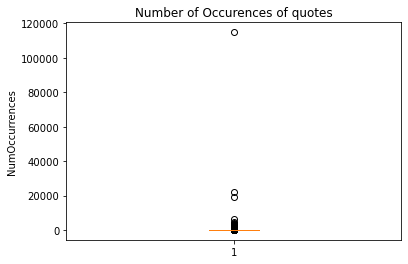

In [35]:
plt.boxplot(freq)
plt.ylabel("NumOccurrences")
plt.title('Number of Occurences of quotes')
plt.show()

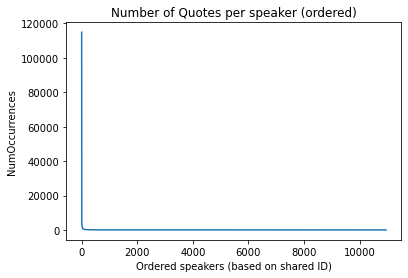

In [36]:
plt.plot(np.arange(len(freq)), freq)
plt.xlabel("Ordered speakers (based on shared ID)")
plt.ylabel("NumOccurrences")
plt.title('Number of Quotes per speaker (ordered)')
plt.show()

We do not regard this as a problem, since it seems reasonable that this depicts the real-world scenario where some people - like star directors and movie stars - have more to say than actors that are not playing in movies at the current time but still gets quoted once in a while.

By looking at the shared_ID, we now see that the ambiguity of speakers is now reduced - which will be useful in further analyses - as the new `shared_ID` attribute captures identical speaker denoted by different names.

In [37]:
N = 25
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    
    info_tuple = (ID[n], freq[n], list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")

Most quoted ID's: 
 (shared_ID, total numOccurrences, associated speakers)

1) (7836, 114892, ['David Caballero'])

2) (3883, 22003, ['John Mackey ,'])

3) (5342, 19381, ['Tom Cruise'])

4) (7091, 6209, ['Kevin Feige', 'KEVIN FEIGE'])

5) (3177, 4478, ['Kathleen Kennedy'])

6) (3985, 3768, ['Donald Trump', 'President Trump', 'President Donald Trump', 'President Donald J. Trump'])

7) (8869, 3305, ['Rian Johnson', 'RIAN JOHNSON'])

8) (7521, 3293, ['Bob Iger', 'Robert Iger', 'Robert A. Iger', 'BOB IGER'])

9) (1926, 3077, ['J.J. Abrams', 'JJ Abrams', 'J. J. Abrams', 'jj abrams', 'J J Abrams', 'J.J. ABRAMS'])

10) (6074, 3011, ['Patty Jenkins', 'PATTY JENKINS', 'patty Jenkins'])

11) (2091, 2869, ['Peter Parker'])

12) (5633, 2566, ['Captain Marvel'])

13) (1480, 2357, ['John Boyega'])

14) (2308, 2350, ['Tom Holland', 'TOM HOLLAND'])

15) (1454, 2311, ['Joe Russo', 'Joseph Russo', 'joe russo'])

16) (2535, 2210, ['Mark Hamill', 'MARK HAMILL'])

17) (10164, 2094, ['Ryan Reynolds'])

18) 

### (Optional) - All occurrences per speaker

In [ ]:
N = len(df)-1
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    
    info_tuple = (ID[n], freq[n], list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")